In [1]:
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle

from scipy.stats import shapiro
from scipy.stats import normaltest


from generation.data.data_preparation import generate_single_detector_output, get_detector_df,\
                                                generate_detector_output, postprocess_step_energies

In [2]:
df = pd.read_pickle("/home/pafakanov/data/hep_data/new_data/particles.pkl")

In [3]:
SAVE_DIR = '/home/pafakanov/data/hep_data/noise_analysis/'

def get_output_signals(detector_df):
    output_signals = []
    for event in tqdm.tqdm(detector_df['event'].unique()):
        detector_event_df = detector_df[detector_df['event'] == event]
        output_signal = generate_single_detector_output(detector_event_df, steps_num=1024, sample_coef=1.0)
        output_signal /= np.max(output_signal)
        output_signals.append(output_signal)

    output_signals = np.array(output_signals)
    return output_signals


def normal_test(noises, method, alpha=0.05):
    is_normal = []
    for noise in noises:
        stat, p = method(noise)

        if p > alpha:
            is_normal.append(1)
        else:
            is_normal.append(0)
    return is_normal


def get_detector_noises(df, detector, mean_option, alpha=0.05, steps_num=1024):
    """
    Return noise for each event for given detector
    """
    
    valid_options = ['global', 'unique']
    if mean_option not in valid_options:
        raise ValueError(f"{mean_option} is not a valid option, try one of {valid_options}")
    
    detector_df = get_detector_df(df, detector=detector)
    output_signals = get_output_signals(detector_df)
    
    if mean_option == 'global':
        mean_signal = generate_single_detector_output(detector_df, steps_num=1024, sample_coef=1.0)
        mean_signal /= np.max(mean_signal)
    elif mean_option == 'unique':
        mean_signal = np.mean(output_signals, axis=0)
        mean_signal /= np.max(mean_signal)
        
    noises = np.array([output_signal - mean_signal for output_signal in output_signals]).T
    return noises
    
    
def test_detector_noise(df, detector, mean_option, alpha=0.05, steps_num=1024, to_save=False, verbose=1):
    noises = get_detector_noises(df, detector, mean_option, alpha, steps_num)
    is_normal_shapiro = normal_test(noises, shapiro, alpha)
    is_normal_normaltest = normal_test(noises, normaltest, alpha)
    
    if verbose > 0:
        f, ax = plt.subplots(1, 2, figsize=(6, 2))
        ax[0].set_title("Mean errors distribution along positions")
        ax[0].hist(np.mean(noises, axis=1))
        ax[1].set_title("Noise example")
        ax[1].plot(noises[:, np.random.choice(range(noises.shape[1]))])
        plt.show()
        
        f, ax = plt.subplots(1, 2, figsize=(6, 2))
        ax[0].set_title("Shapiro test results")
        ax[0].plot(is_normal_shapiro)
        ax[1].set_title("Normaltest test resutls")
        ax[1].plot(is_normal_normaltest)
        plt.show()
    
    if to_save:
        with open(os.path.join(SAVE_DIR, f'shapiro_det-{detector}_meam-{mean_option}_steps-{steps_num}'), 'wb') as file_:
            pickle.dump(is_normal_shapiro, file_)
        with open(os.path.join(SAVE_DIR, f'normaltest_det-{detector}_meam-{mean_option}_steps-{steps_num}'), 'wb') as file_:
            pickle.dump(is_normal_normaltest, file_)

In [ ]:
detector_noises = get_detector_noises(df, 13, 'global')

In [ ]:
is_normal = normal_test(detector_noises, normaltest)
plt.plot(is_normal)
plt.show()

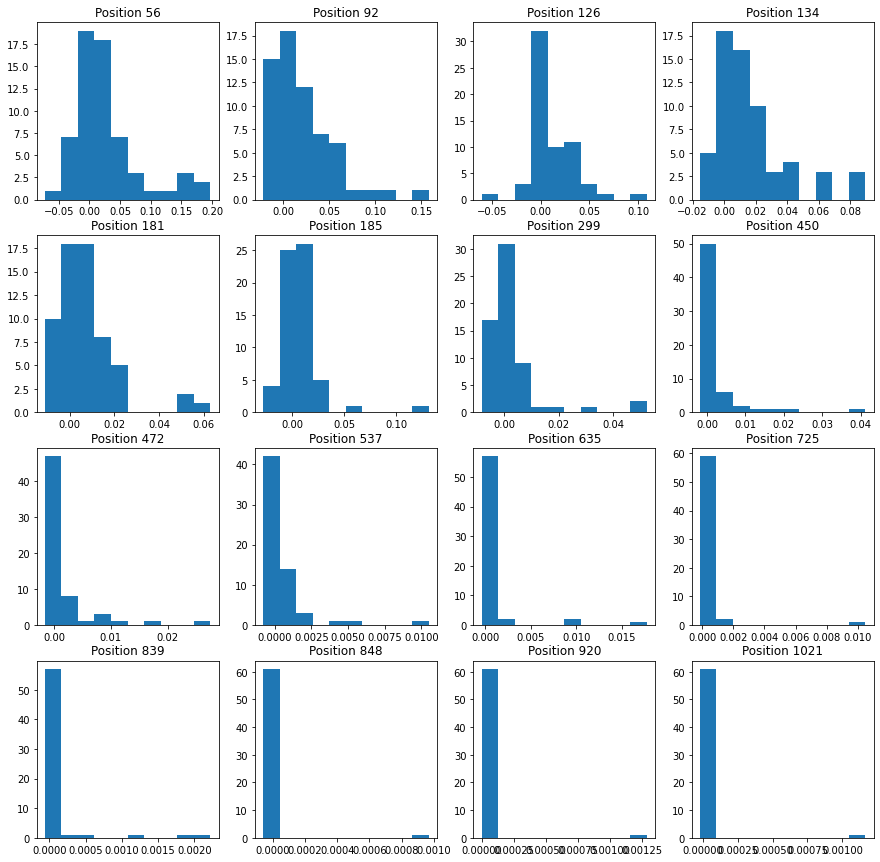

In [64]:
# rows_num = 4
# columns_num = 4

# f, ax = plt.subplots(rows_num, columns_num, figsize=(15, 15))

# random_positions = sorted(np.random.choice(detector_noises.shape[0], size=rows_num*columns_num))

# for idx, pos in enumerate(random_positions):
#     ax[idx//columns_num][idx%columns_num].set_title(f"Position {pos}")
#     ax[idx//columns_num][idx%columns_num].hist(detector_noises[pos])
# plt.show()

Detector: 0.0


100%|██████████| 52/52 [01:16<00:00,  1.47s/it]
/home/pafakanov/data/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1673: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


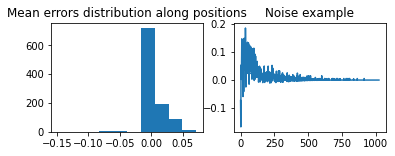

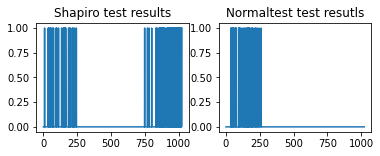

Detector: 1.0


100%|██████████| 62/62 [01:33<00:00,  1.51s/it]
/home/pafakanov/data/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1673: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


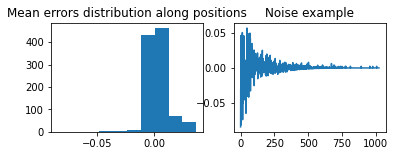

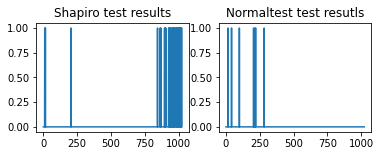

Detector: 2.0


100%|██████████| 45/45 [01:06<00:00,  1.47s/it]
/home/pafakanov/data/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1673: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


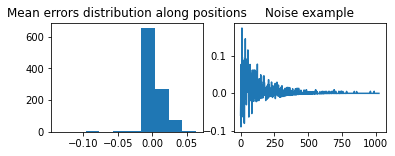

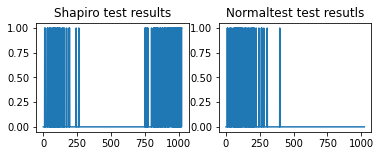

Detector: 3.0


100%|██████████| 59/59 [01:29<00:00,  1.52s/it]
/home/pafakanov/data/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1673: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


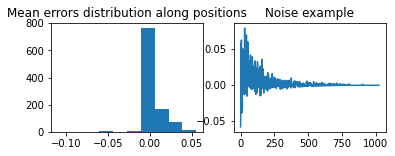

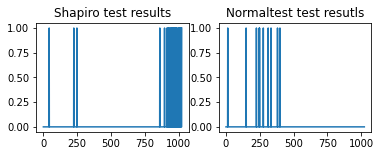

Detector: 4.0


100%|██████████| 74/74 [08:08<00:00,  6.60s/it]


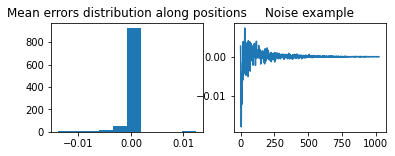

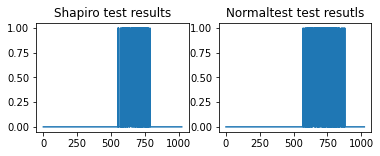

Detector: 5.0


100%|██████████| 66/66 [01:40<00:00,  1.53s/it]
/home/pafakanov/data/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1673: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


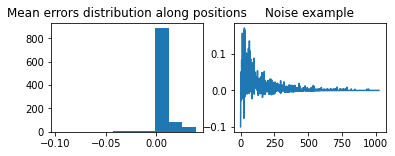

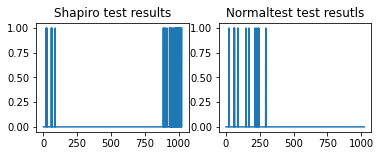

Detector: 6.0


 98%|█████████▊| 46/47 [01:07<00:01,  1.42s/it]

TypeError: No loop matching the specified signature and casting
was found for ufunc true_divide

In [4]:
for detector in sorted(df['detector'].unique()):
    print(f'Detector: {detector}')
    test_detector_noise(df, detector, mean_option='global')

In [ ]:
for detector in sorted(df['detector'].unique()):
    print(f'Detector: {detector}')
    test_detector_noise(df, detector, mean_option='unique')

### First way

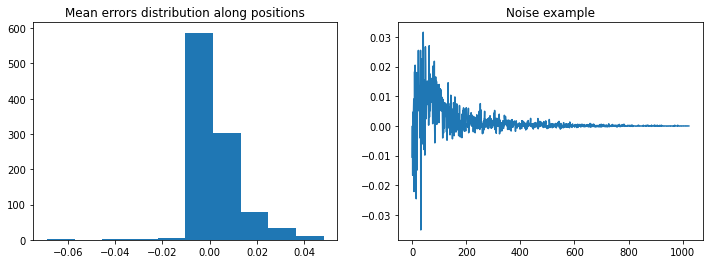

In [4]:
noises = np.array([output_signal - mean_signal for output_signal in output_signals]).T

f, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].set_title("Mean errors distribution along positions")
ax[0].hist(np.mean(noises, axis=1))
ax[1].set_title("Noise example")
ax[1].plot(noises[:, 0])
plt.show()

### Second way

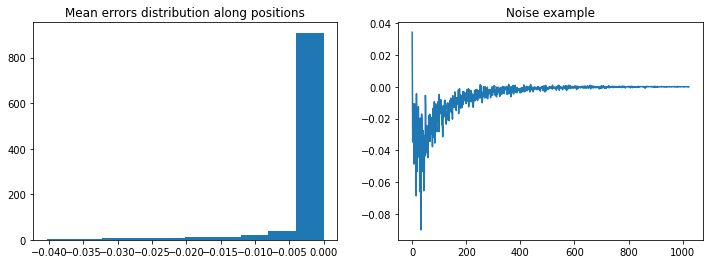

In [5]:
mean_signal_second = np.mean(output_signals, axis=0)
mean_signal_second /= np.max(mean_signal_second)
noises = np.array([output_signal - mean_signal_second for output_signal in output_signals]).T

f, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].set_title("Mean errors distribution along positions")
ax[0].hist(np.mean(noises, axis=1))
ax[1].set_title("Noise example")
ax[1].plot(noises[:, 0])
plt.show()

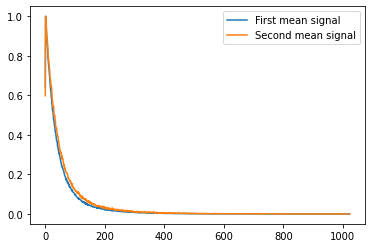

In [6]:
plt.plot(mean_signal)
plt.plot(mean_signal_second)
plt.legend(['First mean signal', 'Second mean signal'])
plt.show()

##### Shapiro test

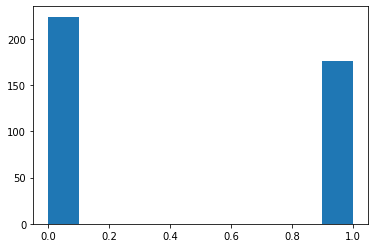

In [8]:
FIRST_POS_NUM = 400
ALPHA = 0.05

is_normal = []
for noise in noises[:FIRST_POS_NUM]:
    stat, p = shapiro(noise)

    if p > ALPHA:
        is_normal.append(1)
    else:
        is_normal.append(0)
        
plt.hist(is_normal)
plt.show()

###### D’Agostino’s K^2 Test

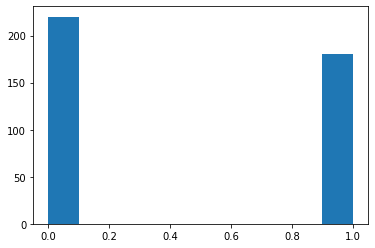

In [9]:
is_normal = []
for noise in noises[:FIRST_POS_NUM]:
    stat, p = normaltest(noise)

    if p > ALPHA:
        is_normal.append(1)
    else:
        is_normal.append(0)

plt.hist(is_normal)
plt.show()